In [4]:
#!pip install -U aeon
#!pip install aeon[all_extras]
import warnings
import pandas as pd
from matplotlib import pyplot as plt
from aeon.visualisation import plot_series
from sklearn.metrics import mean_absolute_percentage_error as mape
from all_functions import *
import os
from aeon.clustering.averaging import elastic_barycenter_average
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from VotingCombination import VotingCombination
from dateutil.relativedelta import relativedelta
from sklearn.svm import SVR
import os
from tslearn.barycenters import \
    euclidean_barycenter, \
    dtw_barycenter_averaging, \
    dtw_barycenter_averaging_subgradient, \
    softdtw_barycenter
warnings.filterwarnings("ignore")
%matplotlib inline

def get_predictions_csv(path, format, start_index):
    df = pd.read_csv(path, sep=";")
    results = {}
    params = {}
    # for format in formats:
    filtered_df = df[df['DATA'] == format]
    
    columns_p1_to_p12 = filtered_df.loc[:, 'P1':'P12']
    
    # values_list = columns_p1_to_p12.values.tolist()
    values_list = columns_p1_to_p12.values.flatten().tolist()     
    results = pd.Series(values_list, index=start_index)
    params = filtered_df['PARAMS'].iloc[0]
            
    return results, params

def get_params_model(caminho_arquivo, transformation):
    df = pd.read_csv(caminho_arquivo, sep=';')
    
    df_filtrado = df[df['DATA'] == transformation]
    params_dict = ast.literal_eval(df_filtrado['PARAMS'].iloc[0])
    
    return params_dict

def convert_to_list(series_str):
    return eval(series_str)

def get_preds_hybrid(path, test_date, start_index):
    df = pd.read_csv(path, sep=";")
    results = {}
    filtered_df = df[df['test_range'] == test_date]
    columns_p1_to_p12 = filtered_df.loc[:, 'P1':'P12']
    values_list = columns_p1_to_p12.values.flatten().tolist()     
    results = pd.Series(values_list, index=start_index)
    return results

def get_error_series(path, test_date):
    df = pd.read_csv(path, sep=";")
    error_series_str = df.loc[df['test_range'] == test_date, 'error_series'].values[0]
    error_list_rf = ast.literal_eval(error_series_str)
    return error_list_rf

def save_csv(nome, csv_file, uf, derivado, models, series, test, preds, horizon=12, window=12):
    y_baseline = series[-horizon*2:-horizon].values
    rmse_result = rmse(test, preds)
    mape_result = mape(test, preds)
    pocid_result = pocid(test, preds)
    pbe_result = pbe(test, preds)
    mcpm_result = mcpm(rmse_result, mape_result, pocid_result)
    mase_result = mase(test, preds, y_baseline)

    df_result = pd.DataFrame({'DATA': nome, 'UF': uf, 'PRODUCT': derivado, 'MODEL':  f"{'_'.join(models)}", 'PARAMS': str({}), 'WINDOW': window, 'HORIZON': horizon,  
                                            'RMSE': rmse_result, 'MAPE': mape_result, 'POCID': pocid_result, 'PBE': pbe_result, 'MASE': mase_result,
                                            'P1': preds[0], 'P2': preds[1], 'P3': preds[2], 'P4': preds[3], 'P5': preds[4],
                                            'P6': preds[5], 'P7': preds[6], 'P8': preds[7], 'P9': preds[8], 'P10': preds[9],
                                            'P11': preds[10], 'P12': preds[11]
                                            }, index=[0])
    df_result.to_csv(csv_file, sep=';', mode='a', header=False, index=False)


def combination_all_time(erros_dict, predicoes_dict):
    n_pontos_erro = len(next(iter(erros_dict.values())))  
    intervalo = 12  
    n_intervalos = n_pontos_erro // intervalo  

    combinacao_predicoes = []
    ponderacoes_por_ponto = []

    for i in range(intervalo):  
        pesos_intervalo = {modelo: 0 for modelo in erros_dict}

        for j in range(n_intervalos): 
            idx = j * intervalo + i  

            erros_ponto = {modelo: abs(float(erros_dict[modelo][idx])) for modelo in erros_dict}
            menor_erro = min(erros_ponto.values())
            
            for modelo in erros_dict:
                if erros_ponto[modelo] == menor_erro:
                    pesos_intervalo[modelo] += 1
                else:
                    pesos_intervalo[modelo] += menor_erro / erros_ponto[modelo]
        
        soma_pesos_intervalo = sum(pesos_intervalo.values())
        pesos_normalizados_intervalo = {modelo: peso / soma_pesos_intervalo for modelo, peso in pesos_intervalo.items()}
        
        predicao_combinada = sum(pesos_normalizados_intervalo[modelo] * predicoes_dict[modelo][i] for modelo in predicoes_dict)
        
        combinacao_predicoes.append(predicao_combinada)
        ponderacoes_por_ponto.append(pesos_normalizados_intervalo)
    
    return combinacao_predicoes, ponderacoes_por_ponto


def combination_val(erros_dict, predicoes_dict):
    n_pontos = len(next(iter(erros_dict.values())))
    combinacao_predicoes = []
    ponderacoes_por_ponto = []

    for i in range(n_pontos):
        pesos = {
            modelo: 1 / abs(float(erros_dict[modelo][i])) 
            for modelo in erros_dict
        }
        
        soma_pesos = sum(pesos.values())
        pesos_normalizados = {modelo: peso / soma_pesos for modelo, peso in pesos.items()}
        
        predicao_combinada = sum(pesos_normalizados[modelo] * predicoes_dict[modelo][i] for modelo in predicoes_dict)
        
        combinacao_predicoes.append(predicao_combinada)
        ponderacoes_por_ponto.append(pesos_normalizados)
    
    return combinacao_predicoes, ponderacoes_por_ponto


def generate_index(start_date, end_date):
    end_date_dt = pd.to_datetime(end_date)
    
    start_date_dt = pd.to_datetime(start_date)
    
    index = pd.period_range(start=start_date_dt, end=end_date_dt, freq='M')

    return index

def get_test_real(series, start_date, end_date):
    start_period = pd.to_datetime(start_date).to_period('M')
    end_period = (pd.to_datetime(end_date))
    
    filtered_series = series.loc[start_period:end_period]

    return filtered_series

def get_train_real(series, start_date):
    start_period = pd.to_datetime(start_date).to_period('M')
    
    filtered_series = series[series.index < start_period]

    return filtered_series


def get_all_error_series(path, test_date):
    df = pd.read_csv(path, sep=";")
    
    df_filtered = df[df['test_range'] <= test_date].copy()

    df_filtered = df_filtered.iloc[::-1]
    
    error_series_concatenated = []
    for _, row in df_filtered.iterrows():
        error_series_str = row['error_series']
        error_list = ast.literal_eval(error_series_str)
        error_series_concatenated.extend(error_list)
    
    return error_series_concatenated

In [5]:
transformations = ["normal", "deseasonal", "log"]
models = ["knn", "rf", "deepar", "svr", "catboost", "arima"]
noResid = True
val_date = '2022-03_2023-02'
test_date = '2023-03_2024-02'
results_file = f'./combination/dynamic/{test_date}'
horizon = 12
window = 12

dirs = [
    '../datasets/venda/mensal/uf/gasolinac/',
    '../datasets/venda/mensal/uf/etanolhidratado/',
    '../datasets/venda/mensal/uf/glp/',
    '../datasets/venda/mensal/uf/oleodiesel/',
    # '../datasets/venda/mensal/uf/querosenedeaviacao/',
]
colunas = ['DATA', 'UF', 'PRODUCT', 'MODEL', 'PARAMS', 'WINDOW', 'HORIZON', 'RMSE', 'MAPE', 'POCID', 'PBE', 'MASE',
           'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12',
           ]

start_date, end_date = test_date.split('_')
test_index = generate_index(start_date, end_date)
for directory in dirs:
    for file in os.listdir(directory) :
        if file.endswith('.csv'):
            uf = file.split("_")[1].upper()
            derivado = file.split("_")[2].split(".")[0]
            full_path = os.path.join(directory, file)
            series = read_series(full_path)
            _, _ = train_test_stats(series, horizon)
            test_real = get_test_real(series, start_date, end_date)

            predictions = {}
            preds_elastic = []
            preds_barycenter = []
            error_models = {}
            
            for model in models:
                for transform in transformations:
                    series_preds = get_preds_hybrid(f'./results_hybrid/{model}/{derivado}/{transform}/transform_{uf}.csv', test_date, test_index)
                    error_serie = get_error_series(f'./results_hybrid/{model}/{derivado}/{transform}/transform_{uf}.csv', val_date)
                    error_models[f'{model}_{transform}'] = error_serie
                    predictions[f'{model}_{transform}'] = series_preds
                    preds_elastic.append(np.array([[series_preds.values]]))
                    preds_barycenter.append(series_preds.values)

                    if noResid:
                        try:
                            series_noresid = get_preds_hybrid(f'./results_hybrid/{model}_noresid/{derivado}/{transform}/transform_{uf}.csv', test_date, test_index)
                            error_serie = get_error_series(f'./results_hybrid/{model}_noresid/{derivado}/{transform}/transform_{uf}.csv', val_date)
                            error_models[f'{model}_noresid_{transform}'] = error_serie             
                            
                            predictions[f'{model}_noresid_{transform}'] = series_noresid
                            preds_elastic.append(np.array([[series_noresid.values]]))
                            preds_barycenter.append(series_noresid.values)
                        except:
                            print(uf)
                            print(model)
                            print(derivado)
                            print(transform)
                            raise ValueError('error')

            # voting = VotingCombination(predictions, combination='median')
            # preds_median = voting.predict()


            preds_dynamic, pond = combination_val(error_models, predictions)
            # print(preds_dynamic)
            # print(pond)
            # break
            path_derivado = results_file + f'/{derivado}'
            csv_file = path_derivado + f"/transform_{uf.upper()}.csv"
            os.makedirs(path_derivado, exist_ok=True)
            if not os.path.exists(csv_file):
                pd.DataFrame(columns=colunas).to_csv(csv_file, sep=';', index=False)


            save_csv("mean", csv_file, uf, derivado, models, series, test_real, preds_dynamic, horizon, window)
     
            # save_csv("median",csv_file, uf, derivado, models, series, test_real, preds_median, horizon, window)

            # voting = VotingCombination(predictions, combination='mean')
            # preds_mean = voting.predict()
            # save_csv("mean",csv_file, uf, derivado, models, series, test_real, preds_mean, horizon, window)

            # preds_softdtw = softdtw_barycenter(preds_barycenter, max_iter=35, gamma=0.01)
            # preds_softdtw = pd.Series(preds_softdtw.flatten().tolist(), index=test_real.index)
            # save_csv("softdtw_barycenter",csv_file, uf, derivado, models, series, test_real, preds_softdtw, horizon, window)

            # preds_dtw_subgradient = dtw_barycenter_averaging_subgradient(preds_barycenter, max_iter=35)
            # preds_dtw_subgradient = pd.Series(preds_dtw_subgradient.flatten().tolist(), index=test_real.index)
            # save_csv("DBA_subgradient", csv_file, uf, derivado, models, series, test_real, preds_dtw_subgradient, horizon, window)

            # preds_dtw_avg = dtw_barycenter_averaging(preds_barycenter, max_iter=35)
            # preds_dtw_avg = pd.Series(preds_dtw_avg.flatten().tolist(), index=test_real.index)
            # save_csv("DBA", csv_file, uf, derivado, models, series, test_real, preds_dtw_avg, horizon, window)

            # capt = np.vstack(preds_elastic)
            # elastic = elastic_barycenter_average(capt, distance="twe", reach=15)
            # preds_elastic = pd.Series(elastic[0].tolist(), index=test_real.index)
            # save_csv("EBA_twe", csv_file, uf, derivado, models, series, test_real, preds_elastic, horizon, window)


In [142]:
error_serie = get_all_error_series(f'./results_hybrid/arima/gasolinac/normal/transform_SP.csv', val_date)
error_serie

[61435.52633338637,
 10835.155243515968,
 24336.995828586747,
 65171.38214482844,
 9255.610405554238,
 23452.93994067976,
 17274.73446161946,
 68475.78249760834,
 58548.23078902345,
 112283.79919765942,
 6752.105850300111,
 26750.806677158806,
 5985.802853893547,
 24483.706636286806,
 92056.0993032931,
 -11001.68779180001,
 575.6816278739134,
 86076.04947981413,
 99571.64273829071,
 98702.5778699533,
 72025.16879678465,
 131413.35656594072,
 137235.0648471038,
 88380.64541196055,
 66624.94578781282,
 12091.1092470492,
 11574.756060311338,
 84490.1255789146,
 30138.057595839608,
 78691.36464613536,
 72715.47830181348,
 110167.29615597753,
 122944.80443075864,
 154039.93237608107,
 105866.2871615226,
 94840.99842548493,
 24066.430558518507,
 5584.560692093568,
 43872.583925654646,
 -21684.806763692177,
 40415.81498287944,
 41078.39985807694,
 41736.31707575347,
 60622.85775810701,
 36603.41359243903,
 100576.24742167827,
 19975.869251088123,
 -9645.47291950765,
 2986.819617887144,
 13696

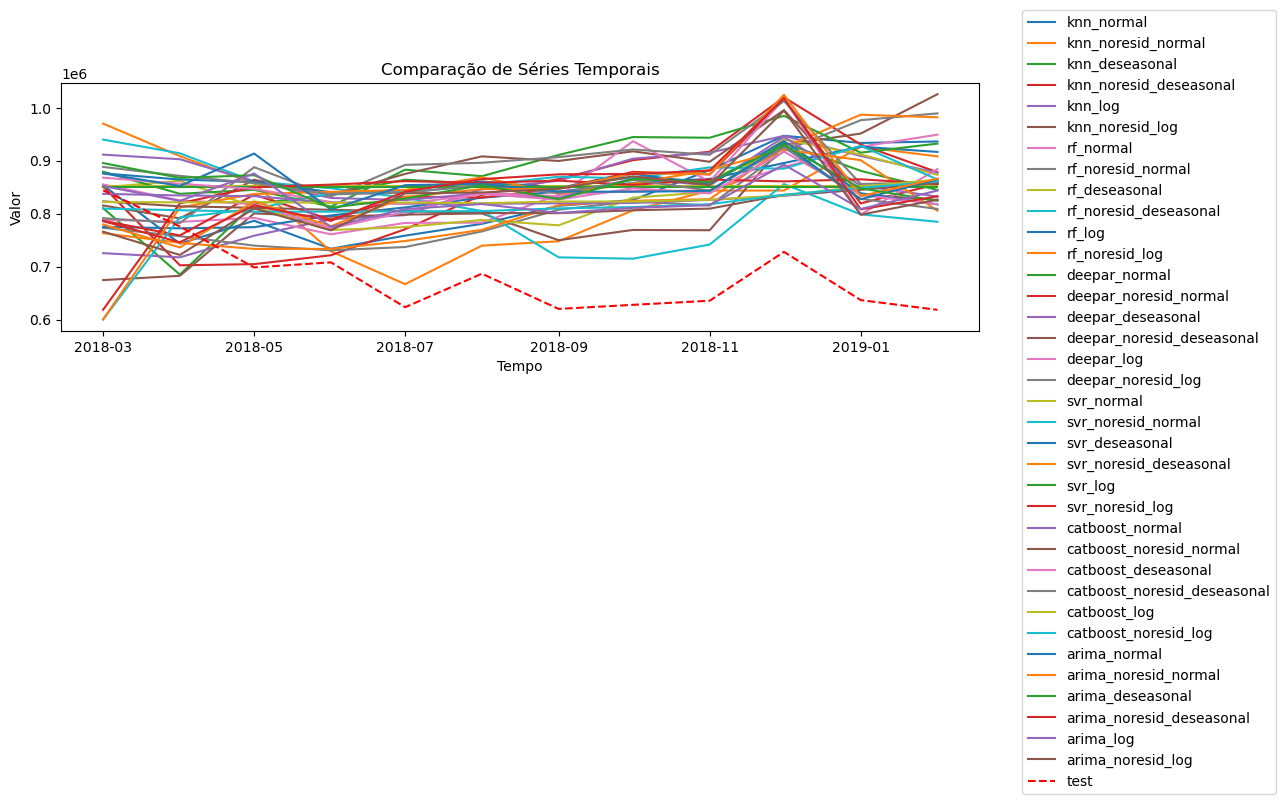

In [112]:
estado = "SP"
derivado = "gasolinac"

val_date = '2022-03_2023-02'
test_date = '2023-03_2024-02'
series = read_series(f'../datasets/venda/mensal/uf/{derivado}/mensal_{estado.lower()}_{derivado}.csv')
predictions_list = {}
test_index = generate_index(start_date, end_date)
# print(test_index)

test_real = get_test_real(series, start_date, end_date)

preds_elastic = []
preds_barycenter = []
for model in models:
    for transform in transformations:
        series_preds = get_preds_hybrid(f'./results_hybrid/{model}/{derivado}/{transform}/transform_{estado}.csv', test_date, test_index)
        error_serie = get_error_series(f'./results_hybrid/{model}/{derivado}/{transform}/transform_{estado}.csv', val_date)
        error_models[f'{model}_{transform}'] = error_serie
        predictions_list[f'{model}_{transform}'] = series_preds
        preds_elastic.append(np.array([[series_preds.values]]))
        preds_barycenter.append(series_preds.values)
    

        if noResid:
            try:
                series_noresid = get_preds_hybrid(f'./results_hybrid/{model}_noresid/{derivado}/{transform}/transform_{estado}.csv', test_date, test_index)
                error_serie = get_error_series(f'./results_hybrid/{model}_noresid/{derivado}/{transform}/transform_{estado}.csv', val_date)
                error_models[f'{model}_noresid_{transform}'] = error_serie             
                
                predictions_list[f'{model}_noresid_{transform}'] = series_noresid
                preds_elastic.append(np.array([[series_noresid.values]]))
                preds_barycenter.append(series_noresid.values)
            except:
                print(uf)
                print(model)
                print(derivado)
                print(transform)
                raise ValueError('error')
            

series_to_plot = []
model_names = []


# for model_name, predictions in predictions_list.items():
#     # Converte a lista de predições em uma pd.Series
#     series_to_plot.append(pd.Series(predictions))
#     model_names.append(model_name)

# series_to_plot.append(pd.Series(test_real))
# model_names.append('test')
# # Plota as séries temporais usando plot_series
# plot_series(*series_to_plot, labels=model_names)

for model_name, predictions in predictions_list.items():
    series_to_plot.append(predictions)
    model_names.append(model_name)

series_to_plot.append(test_real)
model_names.append('test')

def convert_period_to_datetime(series):
    return series.index.to_timestamp(), series.values

plt.figure(figsize=(12, 6))

for i, x in enumerate(series_to_plot[:-1]):
    dt_index, values = convert_period_to_datetime(x)
    plt.plot(dt_index, values, label=model_names[i])

test_dt_index, test_values = convert_period_to_datetime(series_to_plot[-1])
plt.plot(test_dt_index, test_values, label='test', color='red', linestyle='--')

plt.title('Comparação de Séries Temporais')
plt.xlabel('Tempo')
plt.ylabel('Valor')

plt.legend(loc='upper left', bbox_to_anchor=(0.85, 1), bbox_transform=plt.gcf().transFigure)
plt.tight_layout()
plt.show()

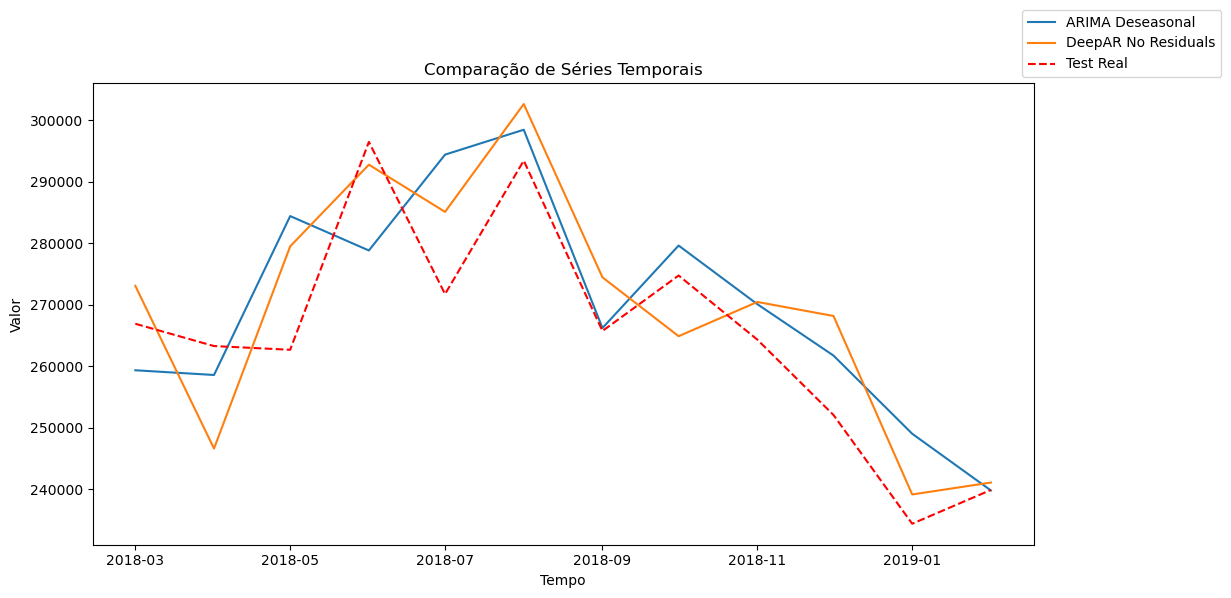

In [128]:
estado = "SP"
derivado = "glp"
val_date = '2022-03_2023-02'
test_date = '2018-03_2019-02'
test_index = generate_index(start_date, end_date)

series = read_series(f'../datasets/venda/mensal/uf/{derivado}/mensal_{estado.lower()}_{derivado}.csv')
test_real = get_test_real(series, start_date, end_date)


series_arima_deseasonal = get_preds_hybrid(f'./results_hybrid/arima/{derivado}/deseasonal/transform_{estado}.csv', test_date, test_index)
series_deepar_noresid= get_preds_hybrid(f'./results_hybrid/deepar_noresid/{derivado}/deseasonal/transform_{estado}.csv', test_date, test_index)
# series_deepar_noresid

series_ad = pd.concat([get_train_real(series, start_date), series_arima_deseasonal])
series_dn = pd.concat([get_train_real(series, start_date), series_deepar_noresid])

series_to_plot = [series_arima_deseasonal, series_deepar_noresid, test_real]
model_names = ['ARIMA Deseasonal', 'DeepAR No Residuals', 'Test Real']

plt.figure(figsize=(12, 6))

for i, x in enumerate(series_to_plot[:-1]):  # Exceto a última série
    dt_index, values = convert_period_to_datetime(x)
    plt.plot(dt_index, values, label=model_names[i])

test_dt_index, test_values = convert_period_to_datetime(series_to_plot[-1])
plt.plot(test_dt_index, test_values, label='Test Real', color='red', linestyle='--')

plt.title('Comparação de Séries Temporais')
plt.xlabel('Tempo')
plt.ylabel('Valor')

plt.legend(loc='upper left', bbox_to_anchor=(0.85, 1), bbox_transform=plt.gcf().transFigure)

plt.tight_layout()

plt.show()

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

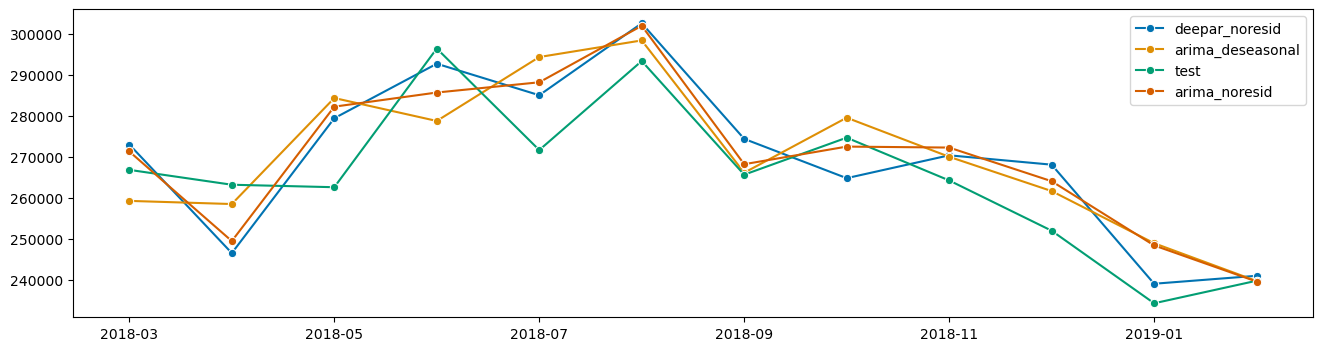

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

def remove_trend(series):
    # decomposition = seasonal_decompose(series, model='additive', period=12)
    # trend = decomposition.trend.dropna()  # Remove NaNs nas bordas
    # detrended_series = series - trendoleodiesel

    transformer = STLTransformer(sp=12) 
    stl = transformer.fit(series)
    detrended = stl.seasonal_ + stl.resid_
    trend = stl.trend_
    return detrended, trend

def remove_resid(series):
    transformer = STLTransformer(sp=12) 
    stl = transformer.fit(series)
    noresid = stl.seasonal_ + stl.trend_
    resid = stl.resid_
    return noresid, resid

def add_trend_from(detrended, trend):
    adjusted = detrended + trend
    return adjusted

def normalize_by(preds_by, preds_to):
    preds_to_norm = znorm(preds_to)

    mean = np.mean(preds_by)
    std = np.std(preds_by)

    return znorm_reverse(preds_to_norm, mean, std)


detrended_deepar, trend_deepar = remove_resid(series_dn)

detrended_arima, trend_arima = remove_resid(series_ad)

adjusted_series = add_trend_from(detrended_arima, trend_deepar)

preds_norm = normalize_by(series_arima_deseasonal, series_deepar_noresid)
preds_adjusted = adjusted_series.tail(12)

series_list = [
    # preds_adjusted,
    series_deepar_noresid,
    series_arima_deseasonal,
    test_real,
    # preds_norm,
    detrended_arima.tail(12)
]

labels_list = [
    # "adjusted",
    "deepar_noresid",
    "arima_deseasonal",
    "test",
    # "renorm",
    "arima_noresid",
]

# Plota as séries temporais usando plot_series
plot_series(*series_list, labels=labels_list)